# [Ateliers: Technologies de l'intelligence Artificielle](https://github.com/wikistat/AI-Frameworks)

<center>
<a href="http://www.insa-toulouse.fr/" ><img src="http://www.math.univ-toulouse.fr/~besse/Wikistat/Images/logo-insa.jpg" style="float:left; max-width: 120px; display: inline" alt="INSA"/></a> 
<a href="http://wikistat.fr/" ><img src="http://www.math.univ-toulouse.fr/~besse/Wikistat/Images/wikistat.jpg" width=400, style="max-width: 150px; display: inline"  alt="Wikistat"/></a>
<a href="http://www.math.univ-toulouse.fr/" ><img src="http://www.math.univ-toulouse.fr/~besse/Wikistat/Images/logo_imt.jpg" width=400,  style="float:right;  display: inline" alt="IMT"/> </a>
    
</center>

# Traitement Naturel du Langage (NLP) : Catégorisation de Produits Cdiscount

Il s'agit d'une version simplifiée du concours proposé par Cdiscount et paru sur le site [datascience.net](https://www.datascience.net/fr/challenge). Les données d'apprentissage sont accessibles sur demande auprès de Cdiscount mais les solutions de l'échantillon test du concours ne sont pas et ne seront pas rendues publiques. Un échantillon test est donc construit pour l'usage de ce tutoriel.  L'objectif est de prévoir la catégorie d'un produit à partir de son descriptif (*text mining*). Seule la catégorie principale (1er niveau, 47 classes) est prédite au lieu des trois niveaux demandés dans le concours. L'objectif est plutôt de comparer les performances des méthodes et technologies en fonction de la taille de la base d'apprentissage ainsi que d'illustrer sur un exemple complexe le prétraitement de données textuelles. 

Le jeux de données complet (15M produits) permet un test en vrai grandeur du **passage à l'échelle volume** des phases de préparation (*munging*), vectorisation (hashage, TF-IDF) et d'apprentissage en fonction de la technologie utilisée.

La synthèse des résultats obtenus est développée par [Besse et al. 2016](https://hal.archives-ouvertes.fr/hal-01350099) (section 5).

## Partie 1 : Exploration et Nettoyage de données textuelles

Dans ce premier notebook nous verrons différent traitements généralement opérés sur des données textuelles :

* **Nettoyage** : Suppression des caractères mal codés et de ponctuation, transformation des majuscules en minuscules, en remarquant que ces transformations ne seraient pas pertinentes pour un objectif de détection de pourriels.
* **StopWord** : Suppression des mots inutiles ou mots de liaison, articles qui n'ont a priori pas de pouvoir discriminant.
* **Stemming** (ou Racinisation): Les mots sont réduits à leur seule racine afin de réduire la taille du dictionnaire.

## Librairies

In [1]:
#Importation des librairies utilisées
import unicodedata 
import time
import pandas as pd
import numpy as np
import random
import nltk
import re 
import collections
import itertools
import warnings
warnings.filterwarnings("ignore")

import matplotlib.pyplot as plt
import seaborn as sb
sb.set_style("whitegrid")

import sklearn.cross_validation as scv

**nltk**

Si vous utilisez la librairie `nltk` pour la première fois, il est nécessaire d'utiliser la commande suivante. Cette commande permet de télécharger de nombreux corpus de texte, mais également des informations grammaticales sur différentes langues. Information notamment nécessaire à l'étape de racinisation.

In [2]:
# nltk.download("all")

## Les données

Dans le dossier *Cdiscount/data* de ce répértoire vous trouverez les fichiers suivants :

* `cdiscount_test.csv.zip`: Fichier d'apprentissage constitué de 1.000.000 de lignes
* `cdisount_test`: Fichier test constitué de 50.000 lignes


   ### Read & Split Dataset
   
   On définit une fonction permettant de lire le fichier d'apprentissage et de créer deux DataFrame Pandas, un pour l'apprentissage, l'autre pour la validation.
   La fonction créée un DataFrame en lisant entièrement le fichier. Puis elle scinde ce DataFrame en deux grâce à la fonction dédiée de sklearn. 

In [3]:
def split_dataset(input_path, nb_line, tauxValid):
    data_all = pd.read_csv(input_path,sep=",", nrows=nb_line)
    data_all = data_all.fillna("")
    data_train, data_valid = scv.train_test_split(data_all, test_size = tauxValid)
    time_end = time.time()
    return data_train, data_valid

Bien que déjà réduit par rapport au fichier original du concours, contenant plus de 15M de lignes, le fichier cdiscount_test.csv.zip, contenant 1M de lignes est encore volumineux. 
Nous allons charger en mémoire qu'une partie de ce fichier grace à l'argument `nb_line` afin d'éviter des temps de calcul trop couteux. 
Nous allons extraire 5% de ces 1M de lignes commes échantillons de validation.

In [4]:
input_path = "data/cdiscount_train.csv.zip"
nb_line=100000  # part totale extraite du fichier initial ici déjà réduit
tauxValid = 0.05
data_train, data_valid = split_dataset(input_path, nb_line, tauxValid)
# Cette ligne permet de visualiser les 5 premières lignes de la DataFrame 
N_train = data_train.shape[0]
N_valid = data_valid.shape[0]
print("Train set : %d elements, Validation set : %d elements" %(N_train, N_valid))

Train set : 95000 elements, Validation set : 5000 elements


La commande suivante permet d'afficher les premières lignes du fichiers. 

Vous pouvez observer que chaque produit possède 3 niveaux de Catégories, qui correspondent au différents niveaux de l'arborescence que vous retrouverez sur le site.
Il y a 44 catégories de niveau 1, 428 de niveau 2 et 3170 de niveau 3. 

Dans ce TP, nous nous interesserons uniquement à classer les produits dans la catégorie de niveau 1.

In [5]:
data_train.head(5)

,Categorie1,Categorie2,Categorie3,Description,Libelle,Marque
18967,TELEPHONIE - GPS,ACCESSOIRE TELEPHONE,COQUE - BUMPER - FACADE TELEPHONE,Coque de protection rigide pour iPhone 6plus -...,Coque de protection rigide pour iPhone 6plus,AUCUNE
96100,AUTO - MOTO (NEW),EQUIPEMENT PILOTE,GANTS - SOUS-GANTS,Gants SHOT MECHANIC noir - Gant spécialement d...,Gants SHOT MECHANIC noir L,AUCUNE
99168,TELEPHONIE - GPS,ACCESSOIRE TELEPHONE,COQUE - BUMPER - FACADE TELEPHONE,Coque Sony Xperia Z Since 1950 Bleu rigide 100...,Coque Sony Xperia Z Since 1950 Bleu rigide 100%…,AUCUNE
38964,TELEPHONIE - GPS,ACCESSOIRE TELEPHONE,COQUE - BUMPER - FACADE TELEPHONE,Coque rigide Rose pour SONY XPERIA Z2 motif Dr...,Coque rigide Rose pour SONY XPERIA Z2 motif Dra…,MUZZANO
19923,INFORMATIQUE,COMPOSANT - PIECE DETACHEE,DALLE D'ECRAN,Dalle d'écran Toshiba Satellite A355-S6944 16 ...,Dalle d'écran Toshiba Satellite A355-S6944 16 ...,AUCUNE


La commande suivante permet d'afficher un exemple de produits pour chaque Catégorie de niveau 1.

In [6]:
data_train.groupby("Categorie1").first()[["Description","Libelle","Marque"]]

,Description,Libelle,Marque
Categorie1,,,
ADULTE - EROTIQUE,Clubwear robe inserts metalliques lingerie se...,Clubwear robe inserts met S/M,AUCUNE
ANIMALERIE - NEW,Manteau pour chien - Auteuil Rouge & Noir (36c...,Manteau pour chien - Auteuil Rouge & Noir (36cm),MARTIN SELLIER
ARME DE COMBAT - ARME DE SPORT,Adaptateur silencieux pour SA1G -14mm antihora...,Adaptateur silencieux pour SA1G -14mm antihoraire,SWISS ARMS
ART DE LA TABLE - ARTICLES CULINAIRES,Koolart Cartoon Mug-De Tomaso-Mangusta-659 - M...,Koolart Cartoon Mug-De Tomaso-Mangusta-659,AUCUNE
ARTICLES POUR FUMEUR,TABAC BLOND VIRGINIA - Taux de nicotine : 16 m...,TABAC BLOND VIRGINIA - Taux de nicotine : 16 mg,AUCUNE
AUTO - MOTO (NEW),Gants SHOT MECHANIC noir - Gant spécialement d...,Gants SHOT MECHANIC noir L,AUCUNE
BAGAGERIE,Porte-Monnaie Nat et Nin reference NNALLY coul...,Porte-Monnaie Nat et Nin reference NNALLY coule…,AUCUNE
BATEAU MOTEUR - VOILIER,Taud télescopique. Pour zodiacs. - Variante: b...,Taud télescopique. Pour zodiacs.,AUCUNE
BIJOUX - LUNETTES - MONTRES,Go Montre Femme 698402 - Cette montre Femme de...,Go Montre Femme 698402,GO


### Distribution des classes

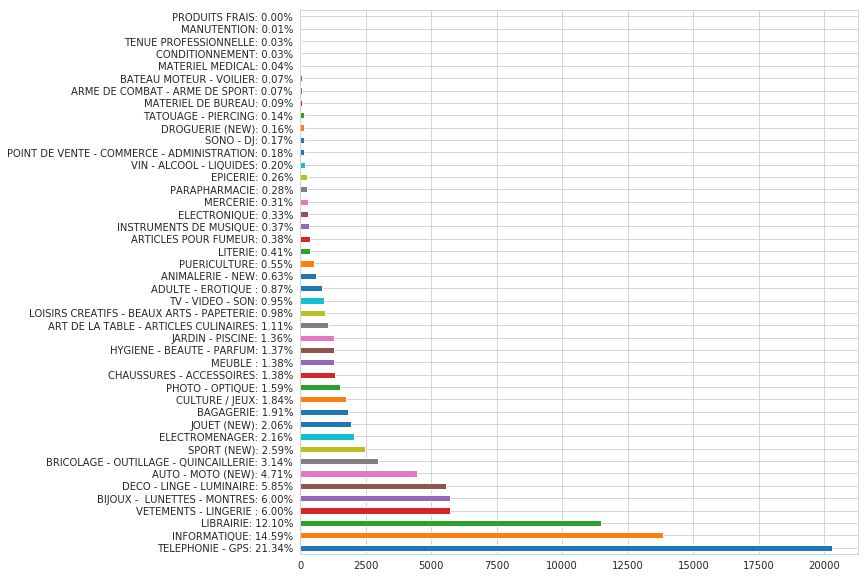

In [7]:
#Count occurence of each Categorie
data_count = data_train["Categorie1"].value_counts()
#Rename index to add percentage
new_index = [k+ ": %.2f%%" %(v*100/N_train) for k,v in data_count.iteritems()]
data_count.index= new_index

fig=plt.figure(figsize= (10,10))
ax = fig.add_subplot(1,1,1)
data_count.plot.barh(logx = False)
plt.show()

**Q** Que peut-on dire sur la distribution de ces classes?

### Sauvegarde des données

On sauvegarde dans des csv les fichiers `train` et `validation` afin que ces mêmes fichiers soit ré-utilisés plus tard dans d'autre calepin

In [8]:
data_valid.to_csv("data/cdiscount_valid.csv", index=False)
data_train.to_csv("data/cdiscount_train_subset.csv", index=False)

##  Nettoyage des données

Afin de limiter la dimension de l'espace des variables ou *features* (i.e les mots présents dans le document), tout en conservant les informations essentielles, il est nécessaire de nettoyer les données en appliquant plusieurs étapes:

* Chaque mot est écrit en minuscule.
* Les termes numériques, de ponctuation et autres symboles sont supprimés.
* 155 mots-courants, et donc non informatifs, de la langue française sont supprimés (STOPWORDS). Ex: le, la, du, alors, etc...
* Chaque mot est "racinisé", via la fonction `STEMMER.stem` de la librairie nltk. La racinisation transforme un mot en son radical ou sa racine. Par exemple, les mots: cheval, chevaux, chevalier, chevalerie, chevaucher sont tous remplacés par "cheva".

### Exemple 

Observons dans un premier temps l'effet de ces différentes étapes sur un  exemple. 

**Ligne Originale**

In [9]:
i = 0
description = data_train.Description.values[i]
print("Original Description : " + description)

Original Description : Coque de protection rigide pour iPhone 6plus - Le Dessin tribale d'Aztec Coloré   Coque pour iPhone 6plus…Voir la présentation


**Suppression des posibles balises HTML dans la description**

Les descriptions produits étant parfois extraites d'autres sites commerçant, des balises HTML peuvent être incluts dans la description. 
La librairie 'BeautifulSoup' permet de supprimer ces balises


In [10]:
from bs4 import BeautifulSoup #Nettoyage d'HTML
txt = BeautifulSoup(description,"html.parser",from_encoding='utf-8').get_text()
print(txt)

Coque de protection rigide pour iPhone 6plus - Le Dessin tribale d'Aztec Coloré   Coque pour iPhone 6plus…Voir la présentation


/home/brendan.guillouet/anaconda3/envs/DEEL/lib/python3.5/site-packages/bs4/__init__.py:179: UserWarning: You provided Unicode markup but also provided a value for from_encoding. Your from_encoding will be ignored.
  warnings.warn("You provided Unicode markup but also provided a value for from_encoding. Your from_encoding will be ignored.")


**Conversion du texte en minuscule**

Certaines mots peuvent être écrits en majuscule dans les descriptions textes, cela à pour conséquence de dupliquer le nombre de features et une perte d'information.

In [11]:
txt = txt.lower()
print(txt)

coque de protection rigide pour iphone 6plus - le dessin tribale d'aztec coloré   coque pour iphone 6plus…voir la présentation


**Remplacement de caractères spéciaux**

Certains caractères spéciaux sont supprimés comme par exemple :

* `\u2026`: `…`
* `\u00a0`: `NO-BREAK SPACE`

Cette liste est non exhaustive et peut être etayée en fonction du jeu de donées étudié, de l'objectif souhaité ou encore du résultat de l'étude explorative.

In [12]:
txt = txt.replace(u'\u2026','.')    
txt = txt.replace(u'\u00a0',' ')
print(txt)

coque de protection rigide pour iphone 6plus - le dessin tribale d'aztec coloré   coque pour iphone 6plus.voir la présentation


**Suppression des accents**

In [13]:
txt = unicodedata.normalize('NFD', txt).encode('ascii', 'ignore').decode("utf-8")
print(txt)

coque de protection rigide pour iphone 6plus - le dessin tribale d'aztec colore   coque pour iphone 6plus.voir la presentation


**Supprime les caractères qui ne sont ne sont pas des lettres minuscules**

Une fois ces premières étapes passées, on supprime tous les caractères qui sont pas des lettres minusculres, c'est à dire les signes de ponctuation, les caractères numériques etc...

In [14]:
txt = re.sub('[^a-z_]', ' ', txt)
print(txt)

coque de protection rigide pour iphone  plus   le dessin tribale d aztec colore   coque pour iphone  plus voir la presentation


**Remplace la description par une liste de mots (tokens), supprime les mots de moins de 2 lettres ainsi que les stopwords**

On va supprimer maintenant tous les mots considérés comme "non-informatif". Par exemple : "le", "la", "de" ...
Des listes contenants ces mots sont proposés dans des libraires tels que *nltk* ou encore *lucène*.

In [15]:
## listes de mots à supprimer dans la description des produits
## Depuis NLTK
nltk_stopwords = nltk.corpus.stopwords.words('french') 
## Depuis Un fichier externe.
lucene_stopwords =open("data/lucene_stopwords.txt","r").read().split(",") #En local
## Union des deux fichiers de stopwords 
stopwords = list(set(nltk_stopwords).union(set(lucene_stopwords)))

stopwords[:10]

['avant',
 'eu',
 'quand',
 'étante',
 'va',
 'ayante',
 'ont',
 'malgré',
 'à',
 'suis']

On applique également la suppression des accents à cette liste

In [16]:
stopwords = [unicodedata.normalize('NFD', sw).encode('ascii', 'ignore').decode("utf-8") for sw in stopwords]
stopwords[:10]

['avant',
 'eu',
 'quand',
 'etante',
 'va',
 'ayante',
 'ont',
 'malgre',
 'a',
 'suis']

Enfin on crée des *tokens*, liste de mots dans la description produit, en supprimant les éléments de notre description produit qui sont présent dans la liste de stopword.

In [17]:
tokens = [w for w in txt.split() if (len(w)>2) and (w not in stopwords)]
remove_words = [w for w in txt.split() if (len(w)<2) or (w in stopwords)]

print(tokens)
print(remove_words)

['coque', 'protection', 'rigide', 'iphone', 'dessin', 'tribale', 'aztec', 'colore', 'coque', 'iphone', 'voir', 'presentation']
['de', 'pour', 'plus', 'le', 'd', 'pour', 'plus', 'la']


**Racinisation (Stem) chaque tokens**

Pour chaque mot de notre liste de token, on va ramener ce mot à sa racine au sens de l'algorithme de Snowball présent dans la librairie **nltk**. 

Cette liste de mots néttoyé et racinisé va constitué les *features* de cette description produits.

In [18]:
## Fonction de setmming de stemming permettant la racinisation
stemmer=nltk.stem.SnowballStemmer('french')
tokens_stem = [stemmer.stem(token) for token in tokens]
print(tokens_stem)

['coqu', 'protect', 'rigid', 'iphon', 'dessin', 'tribal', 'aztec', 'color', 'coqu', 'iphon', 'voir', 'present']


### Fonction de nettoyage de texte

On définit une fonction `clean-txt` qui prend en entrée un texte de description produit et qui retourne le texte nettoyé en appliquant successivement les étapes présentés précedemment. 

On définit également une fonction `clean_marque` qui contient signifcativement moins d'étape de nettoyage. 

In [19]:
# Fonction clean générale
def clean_txt(txt):
    ### remove html stuff
    txt = BeautifulSoup(txt,"html.parser",from_encoding='utf-8').get_text()
    ### lower case
    txt = txt.lower()
    ### special escaping character '...'
    txt = txt.replace(u'\u2026','.')
    txt = txt.replace(u'\u00a0',' ')
    ### remove accent btw
    txt = unicodedata.normalize('NFD', txt).encode('ascii', 'ignore').decode("utf-8")
    ###txt = unidecode(txt)
    ### remove non alphanumeric char
    txt = re.sub('[^a-z_]', ' ', txt)
    ### remove french stop words
    tokens = [w for w in txt.split() if (len(w)>2) and (w not in stopwords)]
    ### french stemming
    tokens_stem = [stemmer.stem(token) for token in tokens]
    ### tokens = stemmer.stemWords(tokens)
    return ' '.join(tokens), " ".join(tokens_stem)

def clean_marque(txt):
    txt = re.sub('[^a-zA-Z0-9]', '_', txt).lower()
    return txt

Applique le nettoyage sur toutes les lignes de la DataFrame et créé deux nouvelles Dataframe (avant et sans l'étape de racinisation).

In [20]:

# fonction de nettoyage du fichier(stemming et liste de mots à supprimer)
def clean_df(input_data, column_names= ['Description', 'Libelle', 'Marque']):

    nb_line = input_data.shape[0]
    print("Start Clean %d lines" %nb_line)
    
    # Cleaning start for each columns
    time_start = time.time()
    clean_list=[]
    clean_stem_list=[]
    for column_name in column_names:
        column = input_data[column_name].values
        if column_name == "Marque":
            array_clean = np.array(list(map(clean_marque,column)))
            clean_list.append(array_clean)
            clean_stem_list.append(array_clean)
        else:
            A = np.array(list(map(clean_txt,column)))
            array_clean = A[:,0]
            array_clean_stem = A[:,1]
            clean_list.append(array_clean)
            clean_stem_list.append(array_clean_stem)
    time_end = time.time()
    print("Cleaning time: %d secondes"%(time_end-time_start))
    
    #Convert list to DataFrame
    array_clean = np.array(clean_list).T
    data_clean = pd.DataFrame(array_clean, columns = column_names)
    
    array_clean_stem = np.array(clean_stem_list).T
    data_clean_stem = pd.DataFrame(array_clean_stem, columns = column_names)
    return data_clean, data_clean_stem

### Nettoyage des DataFrames

In [21]:
# Take approximately 2 minutes fors 100.000 rows
warnings.filterwarnings("ignore")
data_valid_clean, data_valid_clean_stem = clean_df(data_valid)

Start Clean 5000 lines
Cleaning time: 5 secondes


In [22]:
warnings.filterwarnings("ignore")
data_train_clean, data_train_clean_stem = clean_df(data_train)

Start Clean 95000 lines
Cleaning time: 101 secondes


Affiche les 5 premières lignes de la DataFrame d'apprentissage après nettoyage.

In [23]:
data_train_clean.head(5)

,Description,Libelle,Marque
0,coque protection rigide iphone dessin tribale ...,coque protection rigide iphone,aucune
1,gants shot mechanic noir gant specialement dev...,gants shot mechanic noir,aucune
2,coque sony xperia since bleu rigide made franc...,coque sony xperia since bleu rigide,aucune
3,coque rigide rose sony xperia motif drapeau no...,coque rigide rose sony xperia motif dra,muzzano
4,dalle ecran toshiba satellite wxga dalle ecran...,dalle ecran toshiba satellite,aucune


In [24]:
data_train_clean_stem.head(5)

,Description,Libelle,Marque
0,coqu protect rigid iphon dessin tribal aztec c...,coqu protect rigid iphon,aucune
1,gant shot mechanic noir gant special developp ...,gant shot mechanic noir,aucune
2,coqu sony xperi sinc bleu rigid mad franc sony...,coqu sony xperi sinc bleu rigid,aucune
3,coqu rigid ros sony xperi motif drapeau norveg...,coqu rigid ros sony xperi motif dra,muzzano
4,dall ecran toshib satellit wxga dall ecran mat...,dall ecran toshib satellit,aucune


Taille du dictionnaire de mots pour le dataset avant et après la racinisation.

In [28]:
concatenate_text = " ".join(data_train["Description"].values)
list_of_word = concatenate_text.split(" ")
N = len(set(list_of_word))
print(N)

211400


In [25]:
concatenate_text = " ".join(data_train_clean["Description"].values)
list_of_word = concatenate_text.split(" ")
N = len(set(list_of_word))
print(N)

72762


In [26]:
concatenate_text = " ".join(data_train_clean_stem["Description"].values)
list_of_word_stem = concatenate_text.split(" ")
N = len(set(list_of_word_stem))
print(N)

56591


### Wordcloud

In [29]:
from wordcloud import WordCloud

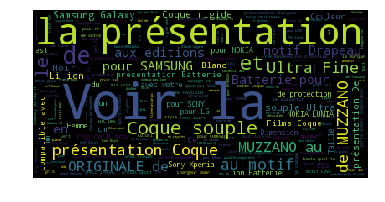

In [30]:
all_descr = " ".join(data_valid.Description.values)
wordcloud_word = WordCloud(background_color="black").generate_from_text(all_descr)

plt.figure()
plt.imshow(wordcloud_word,cmap=plt.cm.Paired)
plt.axis("off")
plt.show()

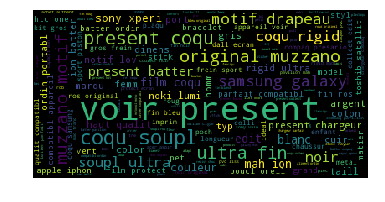

In [31]:
all_descr_clean_stem = " ".join(data_valid_clean_stem.Description.values)
wordcloud_word = WordCloud(background_color="black").generate_from_text(all_descr_clean_stem)

plt.figure()
plt.imshow(wordcloud_word,cmap=plt.cm.Paired)
plt.axis("off")
plt.show()

**Exercice*

## Sauvegarde des jeux de données nettoyés dans des fichiers csv.

In [ ]:
data_valid_clean.to_csv("data/cdiscount_valid_clean.csv", index=False)
data_train_clean.to_csv("data/cdiscount_train_clean.csv", index=False)

data_valid_clean_stem.to_csv("data/cdiscount_valid_clean_stem.csv", index=False)
data_train_clean_stem.to_csv("data/cdiscount_train_clean_stem.csv", index=False)